# Overview

## MintNet – Automated sleep stage scoring using multi-channel EEG data

Deep learning methods exhibit promising performance for predictive modeling in healthcare. Multiple researchers have applied different deep learning models for sleep stage scoring for patients and improve the accuracy close to that of human experts. We have implemented a Convolution Neural Network (CNN) based architecture which has 74-76% prediction accuracy with multi-channel sleep electroencephalogram (EEG) data. This result is very promising and can be extended by applying additional layers to the CNN.

# Install MNE package

In [1]:
!pip install mne

     |████████████████████████████████| 7.0MB 5.4MB/s 


# Setup local drive to save EDF and NPZ files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper methods to process EDF data file.

In [3]:
'''
Reader for EDF+ files.
TODO:
 - add support for log-transformed channels:
   http://www.edfplus.info/specs/edffloat.html and test with
   data generated with
   http://www.edfplus.info/downloads/software/NeuroLoopGain.zip.
 - check annotations with Schalk's Physiobank data.
Copyright (c) 2012 Boris Reuderink.
'''

import re, operator, logging
import numpy as np
from collections import namedtuple
import h5py
import random
from datetime import datetime
EVENT_CHANNEL = 'EDF Annotations'
log = logging.getLogger(__name__)

class EDFEndOfData: pass

WINDOW_SIZE = 100

def rescale_array(X):
    X = X / 20
    X = np.clip(X, -5, 5)
    return X


def aug_X(X):
    scale = 1 + np.random.uniform(-0.1, 0.1)
    offset = np.random.uniform(-0.1, 0.1)
    noise = np.random.normal(scale=0.05, size=X.shape)
    X = scale * X + offset + noise
    return X

def gen(dict_files, aug=False):
    while True:
        record_name = random.choice(list(dict_files.keys()))
        batch_data = dict_files[record_name]
        all_rows = batch_data['x']

        for i in range(10):
            start_index = random.choice(range(all_rows.shape[0]-WINDOW_SIZE))

            X = all_rows[start_index:start_index+WINDOW_SIZE, ...]
            Y = batch_data['y'][start_index:start_index+WINDOW_SIZE]

            X = np.expand_dims(X, 0)
            Y = np.expand_dims(Y, -1)
            Y = np.expand_dims(Y, 0)

            if aug:
                X = aug_X(X)
            X = rescale_array(X)

            yield X, Y


def chunker(seq, size=WINDOW_SIZE):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def tal(tal_str):
  exp = '(?P<onset>[+\-]\d+(?:\.\d*)?)' + \
        '(?:\x15(?P<duration>\d+(?:\.\d*)?))?' + \
        '(\x14(?P<annotation>[^\x00]*))?' + \
        '(?:\x14\x00)'

  def annotation_to_list(annotation):
    # print('annotatn:',annotation)
    return str(annotation).split('\x14') if annotation else []

  def parse(dic):
    return (
    float(dic['onset']), float(dic['duration']) if dic['duration'] else 0., annotation_to_list(dic['annotation']))

  return [parse(m.groupdict()) for m in re.finditer(exp, tal_str)]

def edf_header(f):
    h = {}
    assert f.tell() == 0  # check file position
    assert f.read(8) == '0       '
    # recording info)
    h['local_subject_id'] = f.read(80).strip()
    h['local_recording_id'] = f.read(80).strip()
    # parse timestamp
    (day, month, year) = [int(x) for x in re.findall('(\d+)', f.read(8))]
    (hour, minute, sec) = [int(x) for x in re.findall('(\d+)', f.read(8))]
    h['date_time'] = str(datetime(year + 2000, month, day, hour, minute, sec))
    # misc
    header_nbytes = int(f.read(8))
    subtype = f.read(44)[:5]
    h['EDF+'] = subtype in ['EDF+C', 'EDF+D']
    h['contiguous'] = subtype != 'EDF+D'
    h['n_records'] = int(f.read(8))
    h['record_length'] = float(f.read(8))  # in seconds
    nchannels = h['n_channels'] = int(f.read(4))
    # read channel info
    channels = range(h['n_channels'])
    h['label'] = [f.read(16).strip() for n in channels]
    h['transducer_type'] = [f.read(80).strip() for n in channels]
    h['units'] = [f.read(8).strip() for n in channels]
    h['physical_min'] = np.asarray([float(f.read(8)) for n in channels])
    h['physical_max'] = np.asarray([float(f.read(8)) for n in channels])
    h['digital_min'] = np.asarray([float(f.read(8)) for n in channels])
    h['digital_max'] = np.asarray([float(f.read(8)) for n in channels])
    h['prefiltering'] = [f.read(80).strip() for n in channels]
    h['n_samples_per_record'] = [int(f.read(8)) for n in channels]
    f.read(32 * nchannels)  # reserved
    assert f.tell() == header_nbytes
    return h

class BaseEDFReader:
  def __init__(self, file, verbose=False):
    self.file = file
    self.verbose = verbose

  def read_header(self):
    if self.verbose:
        print('read_header')
    self.header = h = edf_header(self.file)
    # calculate ranges for rescaling
    self.dig_min = h['digital_min']
    self.phys_min = h['physical_min']
    phys_range = h['physical_max'] - h['physical_min']
    dig_range = h['digital_max'] - h['digital_min']
    assert np.all(phys_range > 0)
    assert np.all(dig_range > 0)
    self.gain = phys_range / dig_range

  def read_raw_record(self):
    if self.verbose:
        print('read raw record')
    # Read a record with data and return a list containing arrays with raw bytes.
    result = []
    for nsamp in self.header['n_samples_per_record']:
      samples = self.file.read(nsamp * 2)
      if len(samples) != nsamp * 2:
        raise EDFEndOfData
      result.append(samples)
    return result

  def convert_record(self, raw_record):
    if self.verbose:
        print('convert record')
    # Convert a raw record to a (time, signals, events) tuple based on information in the header.
    h = self.header
    dig_min, phys_min, gain = self.dig_min, self.phys_min, self.gain
    time = float('nan')
    signals = []
    events = []
    for (i, samples) in enumerate(raw_record):
      if h['label'][i] == EVENT_CHANNEL:
        ann = tal(samples)
        time = ann[0][0]
        events.extend(ann[1:])
      # print(i, samples)
      # exit()
      else:
        # 2-byte little-endian integers
        dig = np.fromstring(samples, '<i2').astype(np.float32)
        phys = (dig - dig_min[i]) * gain[i] + phys_min[i]
        signals.append(phys)
    return time, signals, events

  def read_record(self):
    if self.verbose:
        print('read_record')
    return self.convert_record(self.read_raw_record())

  def records(self):
    if self.verbose:
        print('record self')
    # Record generator.
    yield self.read_record()
    """try:
        while True:
            yield self.read_record()
    except EDFEndOfData:
        pass"""

def load_edf(edffile):
  
  """Load an EDF+ file.
    Very basic reader for EDF and EDF+ files. While BaseEDFReader does support
    exotic features like non-homogeneous sample rates and loading only parts of
    the stream, load_edf expects a single fixed sample rate for all channels and
    tries to load the whole file.

    Parameters
    ----------
    edffile : file-like object or string

    Returns
    -------
    Named tuple with the fields:
    X : NumPy array with shape p by n.
    Raw recording of n samples in p dimensions.
    sample_rate : float
    The sample rate of the recording. Note that mixed sample-rates are not
    supported.
    sens_lab : list of length p with strings
    The labels of the sensors used to record X.
    time : NumPy array with length n
    The time offset in the recording for each sample.
    annotations : a list with tuples      EDF+ annotations are stored in (start, duration, description) tuples.
    start : float
      Indicates the start of the event in seconds.
    duration : float
      Indicates the duration of the event in seconds.
    description : list with strings
      Contains (multiple?) descriptions of the annotation event."""
      
  if isinstance(edffile, basestring):
    with open(edffile, 'rb') as f:
      return load_edf(f)  # convert filename to file
  reader = BaseEDFReader(edffile)
  reader.read_header()
  h = reader.header
  log.debug('EDF header: %s' % h)
  # get sample rate info
  nsamp = np.unique(
    [n for (l, n) in zip(h['label'], h['n_samples_per_record'])
     if l != EVENT_CHANNEL])
  assert nsamp.size == 1, 'Multiple sample rates not supported!'
  sample_rate = float(nsamp[0]) / h['record_length']
  rectime, X, annotations = zip(*reader.records())
  X = np.hstack(X)
  annotations = reduce(operator.add, annotations)
  chan_lab = [lab for lab in reader.header['label'] if lab != EVENT_CHANNEL]
  # create timestamps
  if reader.header['contiguous']:
    time = np.arange(X.shape[1]) / sample_rate
  else:
    reclen = reader.header['record_length']
    within_rec_time = np.linspace(0, reclen, nsamp, endpoint=False)
    time = np.hstack([t + within_rec_time for t in rectime])
  tup = namedtuple('EDF', 'X sample_rate chan_lab time annotations')
  return tup(X, sample_rate, chan_lab, time, annotations)

# Required python library

In [4]:
import ntpath
import random, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from mne.datasets.sleep_physionet._utils import _fetch_one, _data_path, AGE_SLEEP_RECORDS, _check_subjects
from datetime import datetime

# Define constants

In [37]:
# Sleep stage constants

W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4
UNKNOWN = 5

#used
label_dict = {
    "W": W,
    "N1": N1,
    "N2": N2,
    "N3": N3,
    "REM": REM,
    "UNKNOWN": UNKNOWN
}
class_labels = [ "W", "N1", "N2", "N3", "REM"]
annot2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
    "Sleep stage ?": 5,
    "Movement time": 5
}
project_path = os.path.abspath(os.getcwd())+'/drive/MyDrive'
print(project_path)

/content/drive/MyDrive


# Configurations values

In [6]:
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}
VBS = True  # constant boolean to enable/disbale verbose
EPOCH_SEC_SIZE = 30  # Epoch duration selection
seed = 42  # seed value for the random seeds
number_of_subj = 80  # Number of patients         
ch_labels =  ['EEG Fpz-Cz', 'EEG Pz-Oz']  # channels to be selected
output_path = os.path.join(project_path, "NPZ_files")  # path to save the npz files
data_path = _data_path
BASE_URL = 'https://physionet.org/physiobank/database/sleep-edfx/sleep-cassette/'
BATCH_SIZE = 50

# Fetching data files from physionet.org and store in current Google drive

We have to use the mne and the pyedflib python library to read the EDF files as it comes with their basic functionalities

In [7]:
#Source : https://github.com/akaraspt/deepsleepnet

def fetch_data(subjects, recording=[1, 2], path=None, force_update=False,
               update_path=None, base_url=BASE_URL,
               verbose=None):  # noqa: D301
    records = np.loadtxt(AGE_SLEEP_RECORDS,
                         skiprows=1,
                         delimiter=',',
                         usecols=(0, 1, 2, 6, 7),
                         dtype={'names': ('subject', 'record', 'type', 'sha',
                                          'fname'),
                                'formats': ('<i2', 'i1', '<S9', 'S40', '<S22')}
                         )
    psg_records = records[np.where(records['type'] == b'PSG')]
    hyp_records = records[np.where(records['type'] == b'Hypnogram')]

    path = data_path(path=path, update_path=update_path)
    params = [path, force_update, base_url]
    fnames = []
    for subject in subjects:
        for idx in np.where(psg_records['subject'] == subject)[0]:
            if psg_records['record'][idx] in recording:
                psg_fname = _fetch_one(psg_records['fname'][idx].decode(),
                                       psg_records['sha'][idx].decode(),
                                       *params)
                hyp_fname = _fetch_one(hyp_records['fname'][idx].decode(),
                                       hyp_records['sha'][idx].decode(),
                                       *params)
                fnames.append([psg_fname, hyp_fname])

    return fnames

# Omitting the subjects with incomplete data
Some of the data is missing i.e., for the first nights of subjects 36 and 52 and the second night for subject 13. 

In [8]:
# Source : https://github.com/akaraspt/deepsleepnet

subjects_list = []  # list to keep the address of the subject data
except_sub = [13, 36, 52]  # omitting the subjects with incomplete data 
for i in range(83):
    if i in except_sub:
        continue
    subjects_list.append(i)
# fetching data of each subject and 
subject_files = fetch_data(subjects=subjects_list, recording=[1, 2], path= project_path)

# Creating the .NPZ files from the EDF raw data

In [9]:
# Source : https://github.com/akaraspt/deepsleepnet

from tqdm.notebook import tqdm
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import psd_welch

#loop to preprocess input data and save the results in npz files to be used in our models later
for item in tqdm(subject_files):
    filename = ntpath.basename(item[0]).replace("-PSG.edf", ".npz")  # reading the PSG files
    if not os.path.exists(os.path.join(output_path, filename)):
        raw_train = mne.io.read_raw_edf(item[0], verbose=VBS)
        sampling_rate = raw_train.info['sfreq']
        raw_ch_df = raw_train.to_data_frame(scalings=100.0)[ch_labels]
        #raw_ch_df = raw_ch_df.to_frame()
        raw_ch_df.set_index(np.arange(len(raw_ch_df)))
        
        # reading the raw headers using the EDFReader function from edfreader
        f = open(item[0], 'r', errors='ignore', encoding='utf-8')
        head_raw_read = BaseEDFReader(f)
        head_raw_read.read_header()
        head_raw = head_raw_read.header
        f.close()
        raw_start_time = datetime.strptime(head_raw['date_time'], "%Y-%m-%d %H:%M:%S")

        # read annotations from hypnogram file
        f = open(item[1], 'r')
        annot_raw_read = BaseEDFReader(f)
        annot_raw_read.read_header()
        annot_raw = annot_raw_read.header
        temp, temp, total_annot = zip(*annot_raw_read.records())
        f.close()
        annot_start_time = datetime.strptime(annot_raw['date_time'], "%Y-%m-%d %H:%M:%S")
        assert raw_start_time == annot_start_time  # making sure that the PSG files and hypnogram files are in sync
        remove_idx = []    # list to keep the indicies of data that will be removed
        labels = []        # list to keep the indicies of data that have labels
        label_idx = []
        
        # selecting the indicies of known labels and adding the rest to remove_idx list
        for annot in total_annot[0]:
            onset_sec, duration_sec, annot_char = annot
            annot_str = "".join(annot_char)
            label = annot2label[annot_str]
            if label != UNKNOWN:
                if duration_sec % EPOCH_SEC_SIZE != 0:
                    raise Exception("Please choose anothe epoch duration!")
                duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
                label_epoch = np.ones(duration_epoch, dtype=np.int) * label
                labels.append(label_epoch)
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
                label_idx.append(idx)
            else:
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
                remove_idx.append(idx)
        labels = np.hstack(labels)
        if len(remove_idx) > 0:
            remove_idx = np.hstack(remove_idx)
            select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
        else:
            select_idx = np.arange(len(raw_ch_df))

        # filtering data with labels only
        label_idx = np.hstack(label_idx)
        select_idx = np.intersect1d(select_idx, label_idx)

        # removing extra indicies
        if len(label_idx) > len(select_idx):
            extra_idx = np.setdiff1d(label_idx, select_idx)
            # trimming the tail
            if np.all(extra_idx > select_idx[-1]):
                n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
                n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
                select_idx = select_idx[:-n_trims]
                labels = labels[:-n_label_trims]

        # removing all unknown and movement labels
        raw_ch = raw_ch_df.values[select_idx]

        # check if we can split into epochs' size
        if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
            raise Exception("Please choose anothe epoch duration!")
        n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

        # get epochs and their corresponding labels
        x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
        y = labels.astype(np.int32)

        assert len(x) == len(y)

        # select on sleep periods
        w_edge_mins = 30
        nw_idx = np.where(y != label_dict["W"])[0]
        start_idx = nw_idx[0] - (w_edge_mins * 2)
        end_idx = nw_idx[-1] + (w_edge_mins * 2)
        if start_idx < 0: start_idx = 0
        if end_idx >= len(y): end_idx = len(y) - 1
        select_idx = np.arange(start_idx, end_idx+1)
        x = x[select_idx]
        y = y[select_idx]

        # file structure for saving
        save_dict = {
            "x": x, 
            "y": y, 
            "fs": sampling_rate,
            "ch_label": ch_labels,
            "header_raw": head_raw,
            "header_annotation": annot_raw,
        }
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        np.savez(os.path.join(output_path, filename), **save_dict)


In [10]:
import glob
npz_files = sorted(glob.glob(os.path.join(output_path, "*.npz")))
X = np.zeros((0, 3000, 2)) # two channel 'EEG Fpz-Cz', 'EEG Pz-Oz'
y = []
for fn in tqdm(npz_files[:number_of_subj]):
    samples = np.load(fn)
    X_data = samples['x']
    X = np.concatenate((X, X_data), axis=0)
    y.extend(samples['y'])
y = np.array(y)

# Visualize dataset

[Text(0, 0, 'W'),
 Text(0, 0, 'N1'),
 Text(0, 0, 'N2'),
 Text(0, 0, 'N3'),
 Text(0, 0, 'REM')]

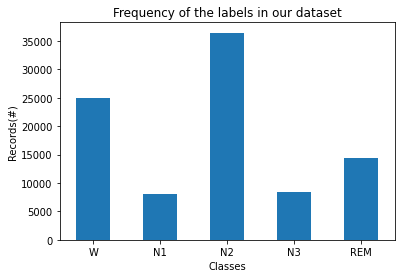

In [51]:
fig = pd.Series(y).value_counts(sort=False).plot.bar()
fig.set_title("Frequency of the labels in our dataset")
fig.set_ylabel("Records(#)")
fig.set_xlabel("Classes")
fig.set_xticklabels(class_labels, rotation=360, ha='center')

# Split the data into traing & test set (80:20)

In [52]:
from sklearn.model_selection import train_test_split
if VBS:
    print("Shape of the input data: {}".format(X.shape))
    print("Shape of the sleep stages: {}".format(y.shape))
# splitting subjects
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train_fpz_cz, X_test_fpz_cz, Y_train_fpz_cz, Y_test_fpz_cz = train_test_split(X[:,:,0:1], y, test_size=0.2, random_state=seed)
X_train_pz_oz, X_test_pz_oz, Y_train_pz_oz, Y_test_pz_oz = train_test_split(X[:,:,1:2], y, test_size=0.2, random_state=seed)

if VBS:
    print("Shape of the training dataset:\ntraining dataset: {}\ntest dataset: {}\n"
          .format(X_train.shape, X_test.shape))
    print("Shape of the training dataset:\ntraining fpz_cz dataset: {}\ntest fpz_cz dataset: {}\n"
          .format(X_train_fpz_cz.shape, X_test_fpz_cz.shape))
    print("Shape of the training dataset:\ntraining pz_oz dataset: {}\ntest pz_oz dataset: {}\n"
          .format(X_train_pz_oz.shape, X_test_pz_oz.shape))
    


Shape of the input data: (92343, 3000, 2)
Shape of the sleep stages: (92343,)
Shape of the training dataset:
training dataset: (73874, 3000, 2)
test dataset: (18469, 3000, 2)

Shape of the training dataset:
training fpz_cz dataset: (73874, 3000, 1)
test fpz_cz dataset: (18469, 3000, 1)

Shape of the training dataset:
training pz_oz dataset: (73874, 3000, 1)
test pz_oz dataset: (18469, 3000, 1)



# Custom dataset
Define the custom dataset

In [53]:
from torch.utils.data import Dataset
class EEGDataset(Dataset):

    def __init__(self, a):
        """
        TODO: init the Dataset instance.
        """
        self.X = a[0]
        self.Y = a[1]

    def __len__(self):
        """
        TODO: Denotes the total number of samples
        """

        return len(self.Y)

    def __getitem__(self, i):
        return (self.X[i], self.Y[i])

# Create data loaders for all channel (fpz-cz & pz-oz), fpz-cz, and pz-oz

In this part, we load the data into the data loader

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# train & test data from fpz-cz and pz_oz
X_train = torch.tensor(X_train).float().detach().clone()
Y_train = torch.tensor(Y_train).long().detach().clone()
train_data_all = (X_train, Y_train)

X_test = torch.tensor(X_test).float().detach().clone()
Y_test = torch.tensor(Y_test).long().detach().clone()
test_data_all = (X_test, Y_test)

train_loader_all = torch.utils.data.DataLoader(EEGDataset(train_data_all), batch_size=BATCH_SIZE, shuffle=False)
test_loader_all =  torch.utils.data.DataLoader(EEGDataset(test_data_all), batch_size=BATCH_SIZE, shuffle=False)

# train & test data from fpz-cz
X_train_fpz_cz = torch.tensor(X_train_fpz_cz).float().detach().clone()
Y_train_fpz_cz = torch.tensor(Y_train_fpz_cz).long().detach().clone()
train_data_fpz_cz = (X_train_fpz_cz, Y_train_fpz_cz)

X_test_fpz_cz = torch.tensor(X_test_fpz_cz).float().detach().clone()
Y_test_fpz_cz = torch.tensor(Y_test_fpz_cz).long().detach().clone()
test_data_fpz_cz = (X_test_fpz_cz, Y_test_fpz_cz)

train_loader_fpz_cz = torch.utils.data.DataLoader(EEGDataset(train_data_fpz_cz), batch_size=BATCH_SIZE, shuffle=False)
test_loader_fpz_cz =  torch.utils.data.DataLoader(EEGDataset(test_data_fpz_cz), batch_size=BATCH_SIZE, shuffle=False)

# train & test data from pz-oz
X_train_pz_oz = torch.tensor(X_train_pz_oz).float().detach().clone()
Y_train_pz_oz = torch.tensor(Y_train_pz_oz).long().detach().clone()
train_data_pz_oz = (X_train_pz_oz, Y_train_pz_oz)

X_test_pz_oz= torch.tensor(X_test_pz_oz).float().detach().clone()
Y_test_pz_oz = torch.tensor(Y_test_pz_oz).long().detach().clone()
test_data_pz_oz = (X_test_pz_oz, Y_test_pz_oz)

train_loader_pz_oz = torch.utils.data.DataLoader(EEGDataset(train_data_pz_oz), batch_size=BATCH_SIZE, shuffle=False)
test_loader_pz_oz =  torch.utils.data.DataLoader(EEGDataset(test_data_pz_oz), batch_size=BATCH_SIZE, shuffle=False)

# Compute training metrics

Define a method to compute metrics of a model based on predicated and ground truth values.

In [60]:
def calculate_batch_accuracy_precision_recall_fscore(y_pred, y_true):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    y_pred = torch.argmax(y_pred, dim=-1)
    y_pred = y_pred.cpu().data.numpy()
    y_true = y_true.cpu().data.numpy()
    (precision, recall, fscore, _) = precision_recall_fscore_support(y_true, y_pred, average='macro',warn_for=tuple())
    accuracy = accuracy_score(y_pred, y_true)
    #print(precision, recall, fscore)
    return precision, recall, fscore, accuracy

# Hyperparameters for training
Define global hyperparameters for the models

In [61]:
n_epoch = 15 # Epoch
lr = .0001 # learning rate
loss_function = nn.CrossEntropyLoss()

# Model training


In [66]:
def train_model(model, train_loader, n_epoch=5, lr=0.003, device=None):
    import torch.optim as optim
    """
    Train the model with default epoch of 5 and learning rate of .003
    """
    device = device or torch.device('cpu') #use CPU if 'device' is not available
   
    loss_history = []

    optimizer = optim.Adam(model.parameters(), lr=lr)
    #optimizer = optim.SGD(model.parameters(), lr=lr)
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    model.train()
    epoch_precision_hist, epoch_recall_hist, epoch_fscore_hist, epoch_accuracy_hist = ([] for i in range(4))

    for epoch in range(n_epoch):
        curr_epoch_loss = []
        precision, recall, fscore, accuracy = ([] for i in range(4))
        count = 0
        for X, Y in train_loader:
            optimizer.zero_grad()
            
            X = X.detach().clone().to(device)
            Y = Y.detach().clone().to(device)
            Y_hat = model(X, device).float()
            Y = Y.long()

            loss = loss_function(Y_hat, Y)
            loss.backward()
            optimizer.step()

            # Appending loss     
            curr_epoch_loss.append(loss.cpu().data.numpy())

            # measure all metrics for the training batch
            batch_precision, batch_recall, batch_fscore, batch_acc = calculate_batch_accuracy_precision_recall_fscore(Y_hat, Y)
            accuracy.append(batch_acc)
            fscore.append(batch_fscore)
            recall.append(batch_recall)
            precision.append(batch_precision)
            count+=1
            #print(count,"/",len(train_loader),"---lr->",lr,"---------acc->", batch_acc, "  --- loss ->", loss)
            print(f"\repoch{epoch} | progress->{count}/{len(train_loader)} ", end="")

        # compute epoch loss i.e. mean of all batch losses and other training metrics
        epoch_accuracy = np.mean(accuracy)
        epoch_accuracy_hist.append(epoch_accuracy)
        epoch_precision_hist.append(np.mean(precision))
        epoch_recall_hist.append(np.mean(recall))
        epoch_fscore_hist.append(np.mean(fscore))

        loss_history.append(round(np.mean(curr_epoch_loss),5))

        print(f"current epoch loss={round(np.mean(curr_epoch_loss),5)},current epoch accuracy={round(epoch_accuracy,5)}")


        #print(f"current epoch loss={round(np.mean(curr_epoch_loss),5)},current epoch accuracy={round(epoch_accuracy,5)},time={datetime.now().strftime("%Y-%m-%d %H:%M")}" )
        #print(datetime.now().strftime("%Y-%m-%d %H:%M"), "epoch_accuracy->", round(epoch_accuracy,5))
        
        exp_lr_scheduler.step() # change learning rate

    return model, loss_history, epoch_accuracy_hist, epoch_precision_hist, epoch_recall_hist, epoch_fscore_hist

# Base model from the paper by Tsinalis,et al. (2016)
Define the CNN architecture based on https://arxiv.org/pdf/1610.01683.pdf



In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SleepCNN_1D_Tsinalis(nn.Module):
    """Replication of the CNN architecture used by Tsinalis,et al. (2016)
    https://arxiv.org/pdf/1610.01683.pdf
    """

    def __init__(self, n = 1):
        super(SleepCNN_1D_Tsinalis, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n, out_channels=20, kernel_size=200, stride=1)
        self.pool1 = nn.MaxPool1d(kernel_size=20, stride=10)
        self.conv2 = nn.Conv2d(
            in_channels=1, out_channels=400, kernel_size=(20, 30), stride=(1, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 10), stride=(1, 2))
        #self.fc1 = nn.Linear(in_features=400 * 721, out_features=500)
        self.fc1 = nn.Linear(in_features=400 * 121, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=5)

    def forward(self, x, dev):
        x = x.permute(0,2,1).to(dev)
        # One dimensional convolution/pooling
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        # Stack, two-dimensional convolution/pooling
        x = x.unsqueeze(1)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        #print(x.shape)
        # Reshape, fully connected layers
        x = x.view(-1, 400 * 121)#400 * 721)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Check for GPU availability
Check if GPU is available, and use it if it is.


In [68]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
  dev = "cuda:0"
  torch.cuda.empty_cache()
else:
  dev = "cpu"
device = torch.device(dev)
print(datetime.now().strftime("%Y-%m-%d %H:%M"))

True
2021-05-06 04:03


# Building the Model

Building a multi-channel model based on SleepCNN_1D_Tsinalis and saving it for future use.

In [69]:
# All the channel
# fpz-cz and pz-oz training 
print('Training with fpz-cz and pz-oz data...')
print('Start time: ', datetime.now().strftime("%Y-%m-%d %H:%M"))

n_dim=2#number of channels which includes fpz-cz and pz-oz

model = SleepCNN_1D_Tsinalis(n_dim)
model = model.to(device)

model, loss_history, epoch_accuracy_hist, epoch_precision_hist, epoch_recall_hist, epoch_fscore_hist = train_model(model, train_loader_all, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model, os.path.join(project_path, "SleepCNN_multichannel.pth"))
print('End time: ', datetime.now().strftime("%Y-%m-%d %H:%M"))


Training with fpz-cz and pz-oz data...
Start time:  2021-05-06 04:03
epoch0 | progress->1478/1478 current epoch loss=1.0954500436782837,current epoch accuracy=0.55555
epoch1 | progress->1478/1478 current epoch loss=0.7236300110816956,current epoch accuracy=0.72082
epoch2 | progress->1478/1478 current epoch loss=0.648580014705658,current epoch accuracy=0.75191
epoch3 | progress->1478/1478 current epoch loss=0.6016299724578857,current epoch accuracy=0.77182
epoch4 | progress->1478/1478 current epoch loss=0.596530020236969,current epoch accuracy=0.77331
epoch5 | progress->1478/1478 current epoch loss=0.5921300053596497,current epoch accuracy=0.77443
epoch6 | progress->1478/1478 current epoch loss=0.5853599905967712,current epoch accuracy=0.77771
epoch7 | progress->1478/1478 current epoch loss=0.5846700072288513,current epoch accuracy=0.77752
epoch8 | progress->1478/1478 current epoch loss=0.5841900110244751,current epoch accuracy=0.77769
epoch9 | progress->1478/1478 current epoch loss=0.5

# Building the Model based on fpz-cz channel data

Building a fpz-cz channel model based on SleepCNN_1D_Tsinalis and saving it for future use.

In [70]:
#fpz-cz training
print('fpz-cz training', datetime.now().strftime("%Y-%m-%d %H:%M"))

n_dim=1#number of channels as its fpz-cz

model_fpz_cz = SleepCNN_1D_Tsinalis(n_dim)
model_fpz_cz = model_fpz_cz.to(device)

model_fpz_cz, loss_history_fpz_cz, epoch_accuracy_hist_fpz_cz, epoch_precision_hist_fpz_cz, epoch_recall_hist_fpz_cz, epoch_fscore_hist_fpz_cz = train_model(model_fpz_cz, train_loader_fpz_cz, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model_fpz_cz, os.path.join(project_path, "SleepCNN_fpz_cz_channel.pth"))

fpz-cz training 2021-05-06 04:11
epoch0 | progress->1478/1478 current epoch loss=1.1728700399398804,current epoch accuracy=0.509
epoch1 | progress->1478/1478 current epoch loss=0.8355699777603149,current epoch accuracy=0.66994
epoch2 | progress->1478/1478 current epoch loss=0.7184900045394897,current epoch accuracy=0.71957
epoch3 | progress->1478/1478 current epoch loss=0.6602399945259094,current epoch accuracy=0.74461
epoch4 | progress->1478/1478 current epoch loss=0.6530600190162659,current epoch accuracy=0.74765
epoch5 | progress->1478/1478 current epoch loss=0.6480600237846375,current epoch accuracy=0.74964
epoch6 | progress->1478/1478 current epoch loss=0.64069002866745,current epoch accuracy=0.75298
epoch7 | progress->1478/1478 current epoch loss=0.6400399804115295,current epoch accuracy=0.75275
epoch8 | progress->1478/1478 current epoch loss=0.6395300030708313,current epoch accuracy=0.75301
epoch9 | progress->1478/1478 current epoch loss=0.6386399865150452,current epoch accuracy

# Building the Model based on pz-oz channel data

Building a pz-oz channel model based on SleepCNN_1D_Tsinalis and saving it for future use.

In [71]:
#pz-oz training
print('pz-oz training', datetime.now().strftime("%Y-%m-%d %H:%M"))
n_dim=1#number of channels as its pz-oz

model_pz_oz = SleepCNN_1D_Tsinalis(n_dim)
model_pz_oz = model_pz_oz.to(device)

model_pz_oz, loss_history_pz_oz, epoch_accuracy_hist_pz_oz, epoch_precision_hist_pz_oz, epoch_recall_hist_pz_oz, epoch_fscore_hist_pz_oz = train_model(model_pz_oz, train_loader_pz_oz, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model_pz_oz, os.path.join(project_path, "SleepCNN_pz_oz_channel.pth"))

pz-oz training 2021-05-06 04:20
epoch0 | progress->1478/1478 current epoch loss=1.1789699792861938,current epoch accuracy=0.5341
epoch1 | progress->1478/1478 current epoch loss=0.7907500267028809,current epoch accuracy=0.68767
epoch2 | progress->1478/1478 current epoch loss=0.7647899985313416,current epoch accuracy=0.69714
epoch3 | progress->1478/1478 current epoch loss=0.733430027961731,current epoch accuracy=0.7104
epoch4 | progress->1478/1478 current epoch loss=0.731190025806427,current epoch accuracy=0.71179
epoch5 | progress->1478/1478 current epoch loss=0.7290999889373779,current epoch accuracy=0.7124
epoch6 | progress->1478/1478 current epoch loss=0.7240200042724609,current epoch accuracy=0.71355
epoch7 | progress->1478/1478 current epoch loss=0.7237499952316284,current epoch accuracy=0.71374
epoch8 | progress->1478/1478 current epoch loss=0.7235000133514404,current epoch accuracy=0.71388
epoch9 | progress->1478/1478 current epoch loss=0.7228900194168091,current epoch accuracy=0

# Model comparison based on loss
Compare loss of multi-channel and single channel performance on the SleepCNN_1D_Tsinalis model.

Text(0, 0.5, 'Cross entropy loss')

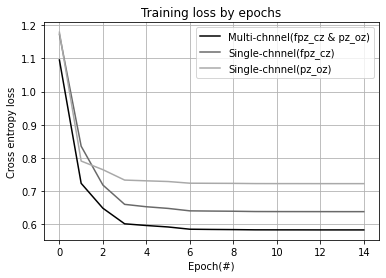

In [72]:
plt.title("Training loss by epochs")
plt.plot(loss_history, label = "Multi-chnnel(fpz_cz & pz_oz)", color ="black")
plt.plot(loss_history_fpz_cz, label = "Single-chnnel(fpz_cz)", color ="dimgrey")
plt.plot(loss_history_pz_oz, label = "Single-chnnel(pz_oz)", color ="darkgrey")
plt.legend()
plt.grid()
plt.xlabel("Epoch(#)")
plt.ylabel("Cross entropy loss")

# Model comparison based on accuracy
Compare accuracy of multi-channel and single channel performance on the SleepCNN_1D_Tsinalis model.

Text(0, 0.5, 'Training accuracy')

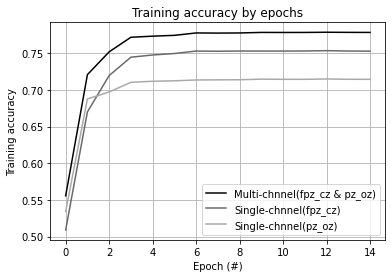

In [73]:
plt.title("Training accuracy by epochs")
plt.plot(epoch_accuracy_hist,label = "Multi-chnnel(fpz_cz & pz_oz)", color ="black")
plt.plot(epoch_accuracy_hist_fpz_cz, label = "Single-chnnel(fpz_cz)", color ="dimgrey")
plt.plot(epoch_accuracy_hist_pz_oz, label = "Single-chnnel(pz_oz)", color ="darkgrey")
plt.legend()
plt.grid()
plt.xlabel("Epoch (#)")
plt.ylabel("Training accuracy")

# Model comparison based on precision
Compare precision of multi-channel and single channel performance on the SleepCNN_1D_Tsinalis model.

Text(0, 0.5, 'Training Precision')

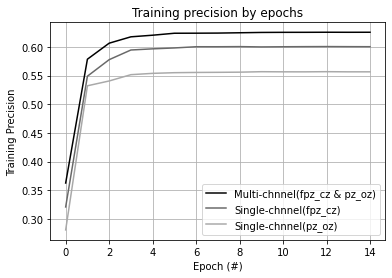

In [74]:
plt.title("Training precision by epochs")
plt.plot(epoch_precision_hist,label = "Multi-chnnel(fpz_cz & pz_oz)", color ="black")
plt.plot(epoch_precision_hist_fpz_cz, label = "Single-chnnel(fpz_cz)", color ="dimgrey")
plt.plot(epoch_precision_hist_pz_oz, label = "Single-chnnel(pz_oz)", color ="darkgrey")
plt.legend()
plt.grid()
plt.xlabel("Epoch (#)")
plt.ylabel("Training Precision")

# Model comparison based on recall
Compare recall of multi-channel and single channel performance on the SleepCNN_1D_Tsinalis model.

Text(0, 0.5, 'Training recall')

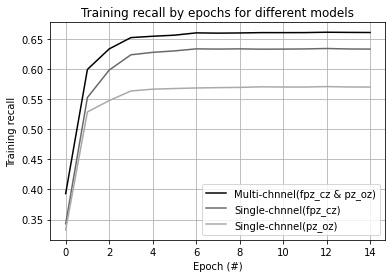

In [75]:
plt.title("Training recall by epochs for different models")
plt.plot(epoch_recall_hist,label = "Multi-chnnel(fpz_cz & pz_oz)", color ="black")
plt.plot(epoch_recall_hist_fpz_cz, label = "Single-chnnel(fpz_cz)", color ="dimgrey")
plt.plot(epoch_recall_hist_pz_oz, label = "Single-chnnel(pz_oz)", color ="darkgrey")
plt.legend()
plt.grid()
plt.xlabel("Epoch (#)")
plt.ylabel("Training recall")

# Model comparison based on f1-score
Compare f1-score of multi-channel and single channel performance on the SleepCNN_1D_Tsinalis model.

Text(0, 0.5, 'Training F1-score')

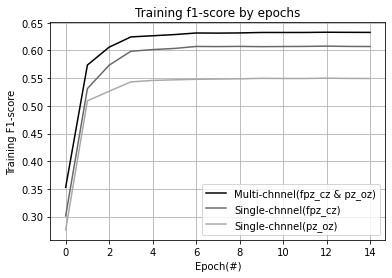

In [76]:
plt.title("Training f1-score by epochs")
plt.plot(epoch_fscore_hist, label = "Multi-chnnel(fpz_cz & pz_oz)", color ="black")
plt.plot(epoch_fscore_hist_fpz_cz, label = "Single-chnnel(fpz_cz)", color ="dimgrey")
plt.plot(epoch_fscore_hist_pz_oz, label = "Single-chnnel(pz_oz)", color ="darkgrey")
plt.legend()
plt.grid()
plt.xlabel("Epoch(#)")
plt.ylabel("Training F1-score")

# Model Evaluation

In [77]:
def eval_model(model, dataloader, device=None):
    """
    Comments goes here
    """
    device = device or torch.device('cpu')
    model.eval()
    pred_all = []
    Y_test = []
    for X, Y in dataloader:
        X = X.detach().clone().to(device)
        Y = Y.detach().clone().to(device)
        Y_hat = model(X, device).float()
        Y_hat = torch.softmax(Y_hat, dim=1)
        pred_all.append(Y_hat.cpu().detach().numpy())
        Y_test.append(Y.cpu().detach().numpy())
    pred_all = np.concatenate(pred_all, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)

    return pred_all, Y_test     

def evaluate_predictions(truth, pred):

    from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    from sklearn.metrics import confusion_matrix
  
    pred_hat = np.argmax(pred, axis=1)

    auroc = roc_auc_score(truth, pred, multi_class='ovr')
    f1 = f1_score(truth, pred_hat, average='micro')
    kappa = cohen_kappa_score(truth, pred_hat)


    #(precision, recall, fscore, _) = precision_recall_fscore_support(truth, pred_hat, average='macro',warn_for=tuple())
    accuracy = accuracy_score(pred_hat, truth)
    cm = confusion_matrix(truth, pred_hat)

    return round(auroc,5), round(f1,5), round(kappa,5), round(accuracy,5),cm


# Building confusion matrix for multi-channel


In [78]:
print("--------final Eval---of all Channels-----")
pred, truth = eval_model(model, test_loader_all, device=device)
auroc, f1, kappa, accuracy,cm = evaluate_predictions(truth, pred)
print(f"All Channels AUROC={auroc} , F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)


--------final Eval---of all Channels-----
All Channels AUROC=0.92695 , F1=0.78098, accuracy =0.78098, and Cohen's Kappa =0.69223
[[4612   13   61    8  271]
 [ 281    9  614    5  712]
 [  86    8 6465  230  583]
 [  11    0  251 1379    1]
 [ 159    8  742    1 1959]]


# Building confusion matrix for fpz-cz channel


In [79]:
print("--------final Eval---of fpz-cz-----")
pred, truth = eval_model(model_fpz_cz, test_loader_fpz_cz, device=device)
auroc, f1, kappa,accuracy,cm = evaluate_predictions(truth, pred)
print(f"fpz-cz channel AUROC={auroc}, F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)


--------final Eval---of fpz-cz-----
fpz-cz channel AUROC=0.91733, F1=0.75743, accuracy =0.75743, and Cohen's Kappa =0.65774
[[4434    0   97   16  418]
 [ 299    0  599    3  720]
 [ 128    0 6469  206  569]
 [  13    0  255 1373    1]
 [ 208    0  947    1 1713]]


# Building confusion matrix for pz-oz channel


In [80]:
print("--------final Eval---of pz-oz-----")
pred, truth = eval_model(model_pz_oz, test_loader_pz_oz, device=device)
auroc, f1, kappa,accuracy,cm = evaluate_predictions(truth, pred)
print(f"pz-oz channel AUROC={auroc} , F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)

--------final Eval---of pz-oz-----
pz-oz channel AUROC=0.89709 , F1=0.71774, accuracy =0.71774, and Cohen's Kappa =0.59631
[[4543    0   88    1  333]
 [ 420    3  601    2  595]
 [ 120    0 6351  328  573]
 [  10    0  592 1033    7]
 [ 286    1 1256    0 1326]]


# Enhanced MintNet model 
Defining MintNet CNN architecture model inspired by CNN architecture of Tsinalis. We have enhanced by adding batch normalization layer between CNN layer. The new architecture is as follows

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SleepCNN_1D_MintNet(nn.Module):
    """MintNet CNN architecture inspired by CNN architecture of Tsinalis,et al. (2016)
    https://arxiv.org/pdf/1610.01683.pdf
    """

    def __init__(self, n = 1):
        super(SleepCNN_1D_MintNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n, out_channels=20, kernel_size=200, stride=1)
        self.bn1 = nn.BatchNorm1d(num_features=20)
        self.pool1 = nn.MaxPool1d(kernel_size=20, stride=10)
        self.conv2 = nn.Conv2d(
            in_channels=1, out_channels=400, kernel_size=(20, 30), stride=(1, 1))
        self.bn2 = nn.BatchNorm2d(num_features=400)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 10), stride=(1, 2))

        self.conv3 = nn.Conv2d(in_channels=400, out_channels=100, kernel_size=(1,10),stride=(1,1))
        self.bn3 = nn.BatchNorm2d(num_features=100)
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 10), stride=(5, 7))

        #self.fc1 = nn.Linear(in_features=400 * 121, out_features=500)
        self.fc1 = nn.Linear(in_features=100*15, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=5)

    def forward(self, x, dev):
        x = x.permute(0,2,1).to(dev)

        # One dimensional convolution/pooling
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        # Stack, two-dimensional convolution/pooling
        x = x.unsqueeze(1)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        # Reshape, fully connected layers
        x = x.view(-1,100*15)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Building the MintNet Model based on multi-channel data

Building a fpz-cz and pz-oz channel model based on SleepCNN_1D_MintNet and saving it for future use.

In [82]:
#fpz-cz and pz-oz training
print('fpz-cz and pz-oz training', datetime.now().strftime("%Y-%m-%d %H:%M"))
n_dim=2#number of channels which includes fpz-cz and pz-oz

model_mintNet = SleepCNN_1D_MintNet(n_dim)
model_mintNet = model_mintNet.to(device)

model_mintNet, loss_history_mintNet, epoch_accuracy_hist_mintNet, epoch_precision_hist_mintNet, epoch_recall_hist_mintNet, epoch_fscore_hist_mintNet = train_model(model_mintNet, train_loader_all, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model_mintNet, os.path.join(project_path, "SleepCNN_multichannel_model_mintNet.pth"))

fpz-cz and pz-oz training 2021-05-06 04:29
epoch0 | progress->1478/1478 current epoch loss=0.5948100090026855,current epoch accuracy=0.77063
epoch1 | progress->1478/1478 current epoch loss=0.4996800124645233,current epoch accuracy=0.80799
epoch2 | progress->1478/1478 current epoch loss=0.47036001086235046,current epoch accuracy=0.82014
epoch3 | progress->1478/1478 current epoch loss=0.4163599908351898,current epoch accuracy=0.84112
epoch4 | progress->1478/1478 current epoch loss=0.4046800136566162,current epoch accuracy=0.84527
epoch5 | progress->1478/1478 current epoch loss=0.3966499865055084,current epoch accuracy=0.848
epoch6 | progress->1478/1478 current epoch loss=0.38589999079704285,current epoch accuracy=0.85333
epoch7 | progress->1478/1478 current epoch loss=0.38436999917030334,current epoch accuracy=0.85381
epoch8 | progress->1478/1478 current epoch loss=0.3833500146865845,current epoch accuracy=0.85425
epoch9 | progress->1478/1478 current epoch loss=0.38203001022338867,curren

# Building the MintNet Model based on fpz-cz channel data

Building a fpz-cz channel model based on SleepCNN_1D_MintNet and saving it for future use.

In [83]:
#fpz-cz training
print('fpz-cz training', datetime.now().strftime("%Y-%m-%d %H:%M"))

n_dim=1#number of channels as its fpz-cz

model_fpz_cz_mintNet = SleepCNN_1D_MintNet(n_dim)
model_fpz_cz_mintNet = model_fpz_cz_mintNet.to(device)

model_fpz_cz_mintNet, loss_history_fpz_cz_mintNet, epoch_accuracy_hist_fpz_cz_mintNet, epoch_precision_hist_fpz_cz_mintNet, epoch_recall_hist_fpz_cz_mintNet, epoch_fscore_hist_fpz_cz_mintNet = train_model(model_fpz_cz_mintNet, train_loader_fpz_cz, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model_fpz_cz_mintNet, os.path.join(project_path, "SleepCNN_fpz_cz_channel_mintNet.pth"))

fpz-cz training 2021-05-06 04:35
epoch0 | progress->1478/1478 current epoch loss=0.6363700032234192,current epoch accuracy=0.75172
epoch1 | progress->1478/1478 current epoch loss=0.5400500297546387,current epoch accuracy=0.79193
epoch2 | progress->1478/1478 current epoch loss=0.5121899843215942,current epoch accuracy=0.8026
epoch3 | progress->1478/1478 current epoch loss=0.4597100019454956,current epoch accuracy=0.82576
epoch4 | progress->1478/1478 current epoch loss=0.4495199918746948,current epoch accuracy=0.82927
epoch5 | progress->1478/1478 current epoch loss=0.4421899914741516,current epoch accuracy=0.83151
epoch6 | progress->1478/1478 current epoch loss=0.43182000517845154,current epoch accuracy=0.83539
epoch7 | progress->1478/1478 current epoch loss=0.43057000637054443,current epoch accuracy=0.83569
epoch8 | progress->1478/1478 current epoch loss=0.429639995098114,current epoch accuracy=0.83582
epoch9 | progress->1478/1478 current epoch loss=0.42833998799324036,current epoch acc

# Building the MintNet Model based on pz-oz channel data

Building a pz-oz channel model based on SleepCNN_1D_MintNet and saving it for future use.

In [84]:
#pz-oz training
print('pz-oz training', datetime.now().strftime("%Y-%m-%d %H:%M"))
n_dim=1#number of channels as its pz-oz

model_pz_oz_mintNet = SleepCNN_1D_MintNet(n_dim)
model_pz_oz_mintNet = model_pz_oz_mintNet.to(device)

model_pz_oz_mintNet, loss_history_pz_oz_mintNet, epoch_accuracy_hist_pz_oz_mintNet, epoch_precision_hist_pz_oz_mintNet, epoch_recall_hist_pz_oz_mintNet, epoch_fscore_hist_pz_oz_mintNet = train_model(model_pz_oz_mintNet, train_loader_pz_oz, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model_pz_oz_mintNet, os.path.join(project_path, "SleepCNN_pz_oz_channel_mintNet.pth"))

pz-oz training 2021-05-06 04:43
epoch0 | progress->1478/1478 current epoch loss=0.7464900016784668,current epoch accuracy=0.70678
epoch1 | progress->1478/1478 current epoch loss=0.6580700278282166,current epoch accuracy=0.74295
epoch2 | progress->1478/1478 current epoch loss=0.6231099963188171,current epoch accuracy=0.7594
epoch3 | progress->1478/1478 current epoch loss=0.5671899914741516,current epoch accuracy=0.78427
epoch4 | progress->1478/1478 current epoch loss=0.5555999875068665,current epoch accuracy=0.78803
epoch5 | progress->1478/1478 current epoch loss=0.5479000210762024,current epoch accuracy=0.79113
epoch6 | progress->1478/1478 current epoch loss=0.5375199913978577,current epoch accuracy=0.79616
epoch7 | progress->1478/1478 current epoch loss=0.5360299944877625,current epoch accuracy=0.79668
epoch8 | progress->1478/1478 current epoch loss=0.5351099967956543,current epoch accuracy=0.79703
epoch9 | progress->1478/1478 current epoch loss=0.5338799953460693,current epoch accura

# Model comparison based on Loss
Compare Loss of multi-channel performance on the SleepCNN_1D_Tsinalis and SleepCNN_1D_MintNet model.

Text(0, 0.5, 'Cross entropy loss')

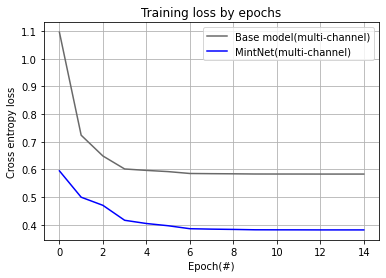

In [85]:
plt.title("Training loss by epochs")
plt.plot(loss_history, label = "Base model(multi-channel)", color="dimgrey")
#plt.plot(loss_history_fpz_cz, label = "fpz_cz")
#plt.plot(loss_history_pz_oz, label = "pz_oz")
plt.plot(loss_history_mintNet, label = "MintNet(multi-channel)", color="blue")
#plt.plot(loss_history_fpz_cz_mintNet, label = "fpz_cz with MintNet")
#plt.plot(loss_history_pz_oz_mintNet, label = "pz_oz with MintNet")
plt.legend()
plt.grid()
plt.xlabel("Epoch(#)")
plt.ylabel("Cross entropy loss")

# Model comparison based on accuracy
Compare accuracy of multi-channel performance on the SleepCNN_1D_Tsinalis and SleepCNN_1D_MintNet model.

Text(0, 0.5, 'Training accuracy')

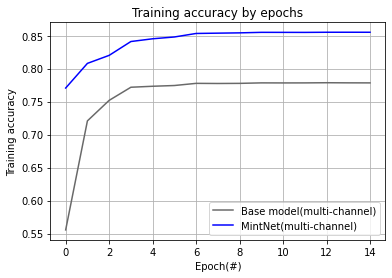

In [86]:
plt.title("Training accuracy by epochs")
plt.plot(epoch_accuracy_hist,label = "Base model(multi-channel)", color="dimgrey")
#plt.plot(epoch_accuracy_hist_fpz_cz, label = "fpz_cz")
#plt.plot(epoch_accuracy_hist_pz_oz, label = "pz_oz")
plt.plot(epoch_accuracy_hist_mintNet,label = "MintNet(multi-channel)", color="blue")
#plt.plot(epoch_accuracy_hist_fpz_cz_mintNet, label = "fpz_cz with MintNet")
#plt.plot(epoch_accuracy_hist_pz_oz_mintNet, label = "pz_oz with MintNet")
plt.legend()
plt.grid()
plt.xlabel("Epoch(#)")
plt.ylabel("Training accuracy")

# Model comparison based on precision
Compare precision of multi-channel performance on the SleepCNN_1D_Tsinalis and SleepCNN_1D_MintNet model.

Text(0, 0.5, 'Training precision')

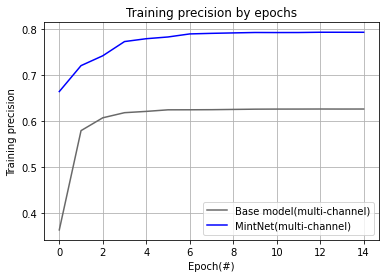

In [87]:
plt.title("Training precision by epochs")
plt.plot(epoch_precision_hist,label = "Base model(multi-channel)", color="dimgrey")
#plt.plot(epoch_precision_hist_fpz_cz, label = "fpz_cz")
#plt.plot(epoch_precision_hist_pz_oz, label = "pz_oz")
plt.plot(epoch_precision_hist_mintNet,label = "MintNet(multi-channel)", color="blue")
#plt.plot(epoch_precision_hist_fpz_cz_mintNet, label = "fpz_cz with MintNet")
#plt.plot(epoch_precision_hist_pz_oz_mintNet, label = "pz_oz with MintNet")
plt.legend()
plt.grid()
plt.xlabel("Epoch(#)")
plt.ylabel("Training precision")

# Model comparison based on recall
Compare recall of multi-channel performance on the SleepCNN_1D_Tsinalis and SleepCNN_1D_MintNet model.

Text(0, 0.5, 'Training recall')

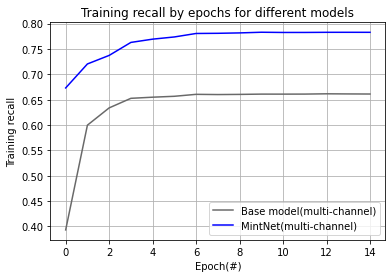

In [88]:
plt.title("Training recall by epochs for different models")

plt.plot(epoch_recall_hist,label = "Base model(multi-channel)", color="dimgrey")
#plt.plot(epoch_recall_hist_fpz_cz, label = "fpz_cz")
#plt.plot(epoch_recall_hist_pz_oz, label = "pz_oz")
plt.plot(epoch_recall_hist_mintNet,label = "MintNet(multi-channel)", color="blue")
#plt.plot(epoch_recall_hist_fpz_cz_mintNet, label = "fpz_cz with MintNet")
#plt.plot(epoch_recall_hist_pz_oz_mintNet, label = "pz_oz with MintNet")
plt.legend()
plt.grid()
plt.xlabel("Epoch(#)")
plt.ylabel("Training recall")

# Model comparison based on f1-score
Compare f1-score of multi-channel performance on the SleepCNN_1D_Tsinalis and SleepCNN_1D_MintNet model.

Text(0, 0.5, 'Training F1-score')

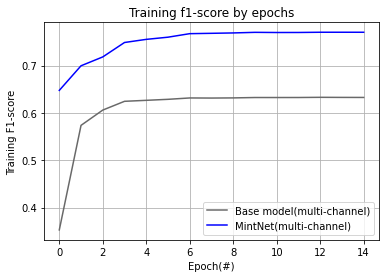

In [89]:
plt.title("Training f1-score by epochs")
plt.plot(epoch_fscore_hist, label = "Base model(multi-channel)", color="dimgrey")
#plt.plot(epoch_fscore_hist_fpz_cz, label = "fpz_cz")
#plt.plot(epoch_fscore_hist_pz_oz, label = "pz_oz")
plt.plot(epoch_fscore_hist_mintNet, label = "MintNet(multi-channel)", color="blue")
#plt.plot(epoch_fscore_hist_fpz_cz_mintNet, label = "fpz_cz with mintNet")
#plt.plot(epoch_fscore_hist_pz_oz_mintNet, label = "pz_oz with mintNet")
plt.legend()
plt.grid()
plt.xlabel("Epoch(#)")
plt.ylabel("Training F1-score")

# Building confusion matrix for multi-channel with MintNet model


In [90]:
print("--------final Eval---of all Channels---MintNet--")
pred, truth = eval_model(model_mintNet, test_loader_all, device=device)
auroc, f1, kappa, accuracy,cm = evaluate_predictions(truth, pred)
print(f"All Channels AUROC={auroc} , F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)

--------final Eval---of all Channels---MintNet--
All Channels AUROC=0.96103 , F1=0.84423, accuracy =0.84423, and Cohen's Kappa =0.7837
[[4730  117   48    2   68]
 [ 223  466  551    3  378]
 [  54  183 6606  178  351]
 [   9    3  253 1377    0]
 [  63  115  278    0 2413]]


# Building confusion matrix for fpz-cz channel with MintNet model


In [91]:
print("--------final Eval---of fpz-cz--MintNet---")
pred, truth = eval_model(model_fpz_cz_mintNet, test_loader_fpz_cz, device=device)
auroc, f1, kappa,accuracy,cm = evaluate_predictions(truth, pred)
print(f"fpz-cz channel AUROC={auroc}, F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)

--------final Eval---of fpz-cz--MintNet---
fpz-cz channel AUROC=0.95615, F1=0.82809, accuracy =0.82809, and Cohen's Kappa =0.76154
[[4686  128   40    2  109]
 [ 252  392  532    4  441]
 [  65  181 6530  180  416]
 [  13    0  278 1350    1]
 [ 131  149  253    0 2336]]


# Building confusion matrix for pz-oz channel with MintNet model


In [92]:
print("--------final Eval---of pz-oz--MintNet---")
pred, truth = eval_model(model_pz_oz_mintNet, test_loader_pz_oz, device=device)
auroc, f1, kappa,accuracy,cm = evaluate_predictions(truth, pred)
print(f"pz-oz channel AUROC={auroc} , F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)

--------final Eval---of pz-oz--MintNet---
pz-oz channel AUROC=0.93534 , F1=0.78716, accuracy =0.78716, and Cohen's Kappa =0.70189
[[4759   36   57    1  112]
 [ 481  121  468   11  540]
 [ 126   80 6340  232  594]
 [  21    1  475 1143    2]
 [ 241   55  398    0 2175]]


#K-fold cross validation...for all channels

In [93]:
'''
https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/

'''

def reset_weights(m):
  '''
  Try resetting model weights to avoid weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

from sklearn.model_selection import KFold


# convert X,y into torch tensor
X_train = torch.tensor(X).float().detach().clone()
Y_train = torch.tensor(y).long().detach().clone()
dataset = (X_train, Y_train)
#print(dataset.shape)

# Configuration options
k_folds = 10
n_dim=2 #number of channels i.e. fpz_cz & pz-oz

# For fold results
# results = {}
auroc_all = [] 
f1_all = [] 
kappa_all = [] 
accuracy_all = []

# Set fixed random number seed
torch.manual_seed(seed)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

print(f'Start time: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(EEGDataset(dataset))):
  
  # Start print
  print('--------------------------------')
  print(f'FOLD {fold}')
  print('--------------------------------')

  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(EEGDataset(dataset), 
                      batch_size=BATCH_SIZE, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(EEGDataset(dataset),
                      batch_size=BATCH_SIZE, sampler=test_subsampler)
  

  # Init the neural network
  model_mintNet = SleepCNN_1D_MintNet(n_dim)
  model_mintNet = model_mintNet.to(device) #use GPU
  model_mintNet.apply(reset_weights)

  model_mintNet, epoch_loss, epoch_accuracy, epoch_precision, epoch_recall, epoch_fscore = train_model(model_mintNet, 
                                                                                                        trainloader, 
                                                                                                        n_epoch=n_epoch, 
                                                                                                        lr=lr, 
                                                                                                        device=device)
  # Process is complete.
  print('Training process has finished. Saving trained model.')

  # Saving the model
  # torch.save(model_mintNet, os.path.join(project_path+str(fold), "model_mintNet.pth"))

  # Print about testing
  print('----------------------------------')
  print('Starting testing...')
  print('----------------------------------')

  pred, truth = eval_model(model_mintNet, testloader, device=device)
  auroc, f1, kappa, accuracy,cm = evaluate_predictions(truth, pred)
  print(f"All Channels AUROC={auroc} , F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")

  auroc_all.append(auroc)
  f1_all.append(f1)
  kappa_all.append(kappa) 
  accuracy_all.append(accuracy)

  #print(cm)

print(f"{fold} average AUROC={np.mean(auroc_all)} , F1={np.mean(f1_all)}, accuracy ={np.mean(accuracy_all)}, and Cohen's Kappa ={np.mean(kappa_all)}")
print(f'End time: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Start time: 2021-05-06 04:52
--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv1d(2, 20, kernel_size=(200,), stride=(1,))
Reset trainable parameters of layer = BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(1, 400, kernel_size=(20, 30), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(400, 100, kernel_size=(1, 10), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=1500, out_features=500, bias=True)
Reset trainable parameters of layer = Linear(in_features=500, out_features=5, bias=True)
epoch0 | progress->1663/1663 current epoch loss=0.5878900289535522,current epoch accuracy=0.771